In [1]:
import ROOT
from ROOT import TFile
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import copy
import pandas as pd 
import time
from os import listdir

Welcome to JupyROOT 6.15/01


In [2]:
class particle:
    def __init__(self, pid, fourvector, virtual_photon):
        
        mass_proton = 0.938
        E_proton    = 40
        E_electron  = 5
        
        incoming_e = ROOT.TLorentzVector()
        incoming_e.SetPxPyPzE(0,0,+E_electron,E_electron)
    
        self.proton = ROOT.TLorentzVector()
        self.proton.SetPxPyPzE(0,0,-E_proton, E_proton)
        
        self.virtual_photon = virtual_photon 
        Nu = virtual_photon.E()
        Q2 = -virtual_photon.M2()
        self.W = (virtual_photon + self.proton).M()
        part1 = virtual_photon.Vect().Cross(incoming_e.Vect()).Unit()
        part2 = virtual_photon.Vect().Cross(fourvector.Vect()).Unit()
        sign  = np.sign(part1.Dot(fourvector.Vect()))
        self.PhiPQ = sign*np.arccos(part1.Dot(part2))
        
        ##Hadron variables
        
        self.LorentzVector = fourvector #hadron four-vector ()
        self.PhiLab = self.LorentzVector.Phi()
        self.E = self.LorentzVector.E() #energy in lab frame
        self.vector = self.LorentzVector.Vect()
        self.Pt = self.vector.Perp(virtual_photon.Vect().Unit()) #pT with respect to photon direction
        self.pid = pid
        self.Zh = fourvector.Dot(self.proton)/virtual_photon.Dot(self.proton)
        #print ' Pz, E hadron' , fourvector.Pz(), ' ' , fourvector.E()
        #print ' Pz, E proton' , self.proton.Pz(),  ' ' , self.proton.E()
        #print ' Dot = ' , fourvector.Dot(self.proton)
        #print 'my version of inelasticity', virtual_photon.Dot(self.proton)/incoming_e.Dot(self.proton)
        #print 'my version of nu ', virtual_photon.Dot(self.proton)/mass_proton
        #print 'my version of x ' , Q2/(2*virtual_photon.Dot(self.proton))
        #print 'my version of zH', self.Zh
    def print_properties(self):
        print 'Hello, let me introduce myself, i am particle pid = ' , self.pid
        print 'zh = ', self.Zh, ' phi_pq= ', self.PhiPQ, ' theta_pq=' , self.ThetaPQ, 'E = ', self.E, ' xf', self.Xf,'Pt ', self.Pt, ' Pl= ', self.Pl, ' rapidity=' ,  self.y


In [3]:
class mytupla:
    def __init__(self):
        self.tupla = {}
        variables = ['dphi','z','z_asso','z_tot','pid','pid_asso','phi_pq','phi_pq_asso',
                      'mass', 'Q2','Xb','Nu','W']
        
        for var in variables:
            self.tupla[var] = []
        
        trigger_variables = ['pid','z','Q2','Xb','Nu','y','W','phi_pq','TargType']
        
        self.tupla_trigger = {}
        for var in trigger_variables:
            self.tupla_trigger[var] = []    

In [4]:

def getDataframes(filename, Target=1,maxevents=1e9):
    
    mass_proton = 0.938
    E_proton    = 40
    E_electron  = 5
    
    dphi = np.array([])
    ParticlesFromPrevious = []
    try:
        myfile = TFile.Open('%s'%filename,'READ')
    except:
        print("could not open file")

        
    myfile.Print()
    mytree = myfile.Get('RootTuple')
    
    print filename, ' has ', mytree.GetEntries(), ' entries'
    print 'The max number of events to be analyzes is ', maxevents
    df = mytupla()    
    
    start = time.time()
    for ievt  in range(mytree.GetEntries()):
        if(ievt%1e5==0):
            print 'Event # ', ievt
            end = time.time()
            print 'Processed in',  end-start, 'seconds'
            start = time.time()
        mytree.GetEntry(ievt)   
        if mytree.Q2<1.0: continue
        if ievt>maxevents: break
        Nu = mytree.nu
        Q2 = mytree.Q2
        x  = Q2/(2*mass_proton*Nu)
        s  = 4*E_electron*E_proton
        y  = Q2/(s*x)
        #print'correct inelasticity', y
        #print 'correct nu', Nu
        #print ' correct x ', x
        phi_e = mytree.phiL 
        Eprime = Q2/(4*E_electron) + (1-y)*E_electron
        
        incoming_e = ROOT.TLorentzVector()
        incoming_e.SetPxPyPzE(0,0,+E_electron,E_electron)
    
        proton = ROOT.TLorentzVector()
        proton.SetPxPyPzE(0,0,-E_proton, E_proton)
    
        #scattered electron in the lab frame
        scattered_e = ROOT.TLorentzVector()
        cos_thetae = 1-Q2/(2*E_electron*Eprime)
        sin_thetae = np.sqrt(1-cos_thetae*cos_thetae)
        #This is the electron in the lab frame
        scattered_e.SetPxPyPzE(Eprime*sin_thetae*np.cos(phi_e),
                               Eprime*sin_thetae*np.sin(phi_e),
                               Eprime*cos_thetae,
                               Eprime)
        #This is the virtual photon in the lab frame
        virtual_photon  = incoming_e - scattered_e
        virtual_photon_unitvector = virtual_photon.Vect().Unit()

    

        for i in range(len(mytree.Px)):
            if abs(mytree.barcode[i]) !=211: continue
            i_lv = ROOT.TLorentzVector()    
            i_lv.SetPxPyPzE(mytree.Px[i],mytree.Py[i],-mytree.Pz[i],mytree.E[i])
            i_part = particle(mytree.barcode[i], i_lv, virtual_photon)
            if i_part.Zh > 0.5:
                df.tupla_trigger['TargType'].append(999)
                df.tupla_trigger['pid'].append(i_part.pid)
                df.tupla_trigger['z'].append(i_part.Zh)

                df.tupla_trigger['phi_pq'].append(i_part.PhiPQ)
                df.tupla_trigger['Q2'].append(Q2)
                df.tupla_trigger['Xb'].append(x)
                df.tupla_trigger['Nu'].append(Nu)
                df.tupla_trigger['y'].append(y)
                df.tupla_trigger['W'].append(i_part.W)
   
                
                for j in range(len(mytree.Px)): 
                    if i==j: continue
                    if abs(mytree.barcode[j]) !=211: continue
                    j_lv = ROOT.TLorentzVector()    
                    j_lv.SetPxPyPzE(mytree.Px[j],mytree.Py[j],-mytree.Pz[j],mytree.E[j])
                    j_part = particle(mytree.barcode[j], j_lv, virtual_photon)
                    
                    dphi = abs(ROOT.TVector2.Phi_mpi_pi(i_part.PhiPQ-j_part.PhiPQ))
                    dipion = i_part.LorentzVector+j_part.LorentzVector

                        
                    df.tupla['dphi'].append(dphi)
                    df.tupla['z'].append(i_part.Zh)
                    df.tupla['z_asso'].append(j_part.Zh)
                    df.tupla['z_tot'].append(i_part.Zh+j_part.Zh)
                    df.tupla['pid'].append(i_part.pid)
                    df.tupla['pid_asso'].append(j_part.pid)
                    df.tupla['phi_pq'].append(i_part.PhiPQ)
                    df.tupla['phi_pq_asso'].append(j_part.PhiPQ)
                    df.tupla['mass'].append(dipion.M())
                    df.tupla['Q2'].append(Q2)
                    df.tupla['Xb'].append(x)
                    df.tupla['Nu'].append(Nu)
                    df.tupla['W'].append(i_part.W)


        
    end = time.time()
    print 'Processed in',  end-start, 'seconds'
    df_pair = pd.DataFrame(df.tupla)
    df_trigger = pd.DataFrame(df.tupla_trigger)
    return df_pair, df_trigger

In [5]:
df = {}

In [6]:
df['Pb'], df['Pb_trigger'] = getDataframes('GiBUU_AuEIC5_50.root',maxevents=5e6)

GiBUU_AuEIC5_50.root  has  133960  entries
The max number of events to be analyzes is  5000000.0
Event #  0
Processed in 0.00726008415222 seconds
Event #  100000
Processed in 263.658113003 seconds
Processed in 86.6729001999 seconds
TFile: name=GiBUU_AuEIC5_50.root, title=, option=READ


In [7]:
import root_pandas
from root_pandas import read_root
from root_pandas import to_root 

## Save dataframes to ROOT files

In [8]:
to_root(df['Pb'],'GiBUU_Pairs_EICAu.root', key='Pb')
to_root(df['Pb_trigger'],'GiBUU_Pairs_EICAu.root', key='Pb_trigger', mode='a')

## Check dataframes variables

9054


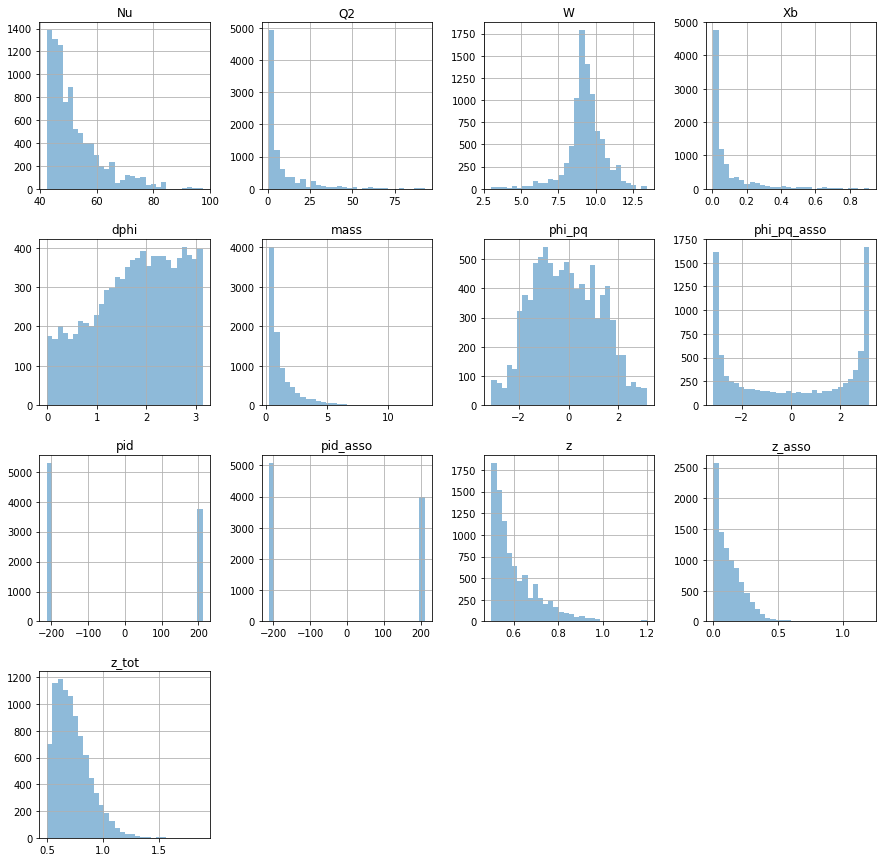

In [9]:
print df['Pb'].shape[0]
df['Pb'].hist(figsize=(15, 15),alpha=0.5,bins=30)
plt.show()

1021


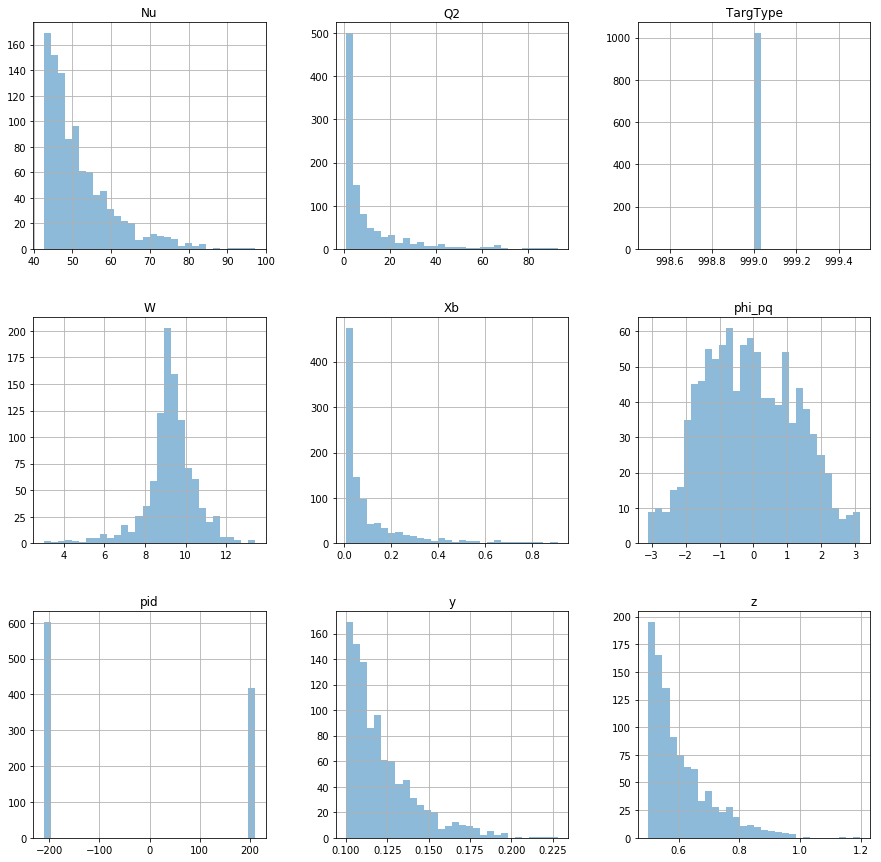

In [10]:
print df['Pb_trigger'].shape[0]
df['Pb_trigger'].hist(figsize=(15, 15),alpha=0.5,bins=30)
plt.show()

In [11]:
y_D, x , _  = plt.hist(df['D']['z_asso'],bins=100,normed=True,alpha=0.7,label='D')
y_C, x , _  = plt.hist(df['C']['z_asso'],bins=100,normed=True,alpha=0.7,label='C')
x = (x[1:] + x[:-1])/2.0
plt.legend()
plt.show()

KeyError: 'D'

In [ ]:
ratio = np.divide(y_C, y_D)
plt.errorbar(x, ratio, marker='o')

plt.ylim([0.0,2.5])
plt.show()